[*********************100%***********************]  1 of 1 completed


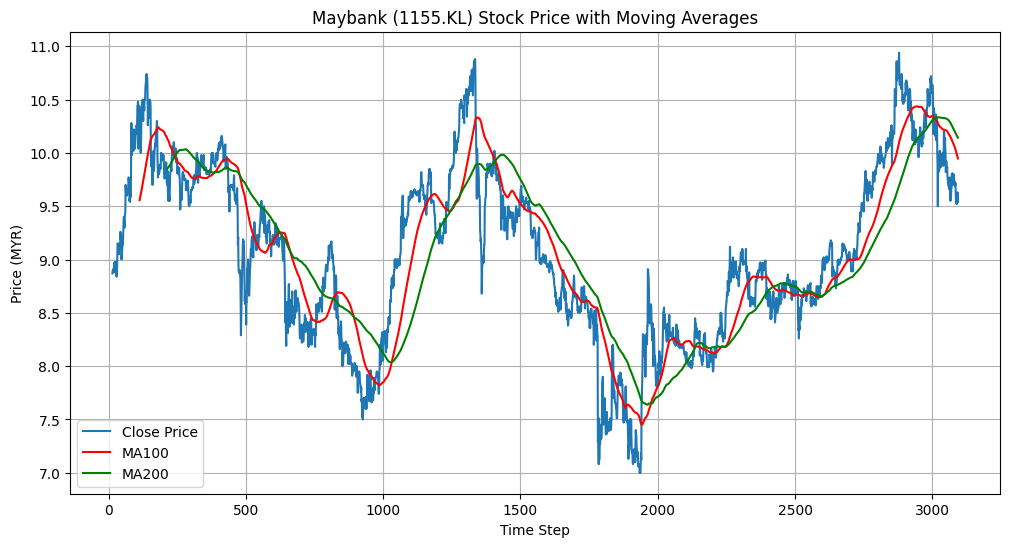

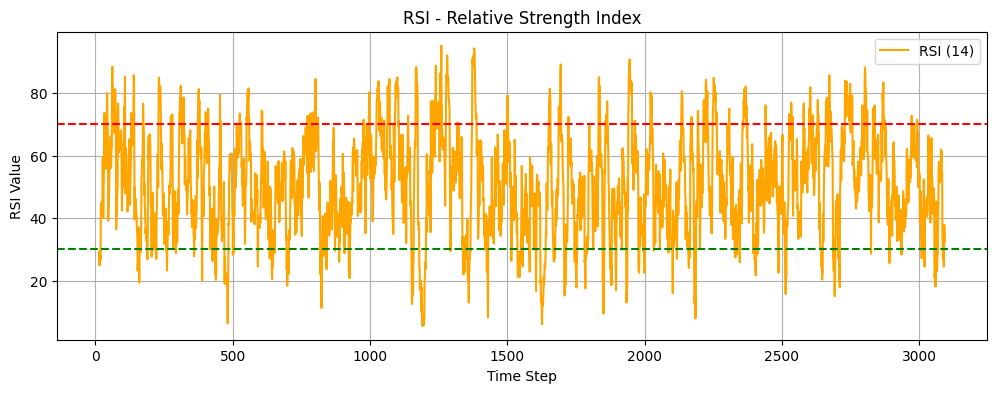

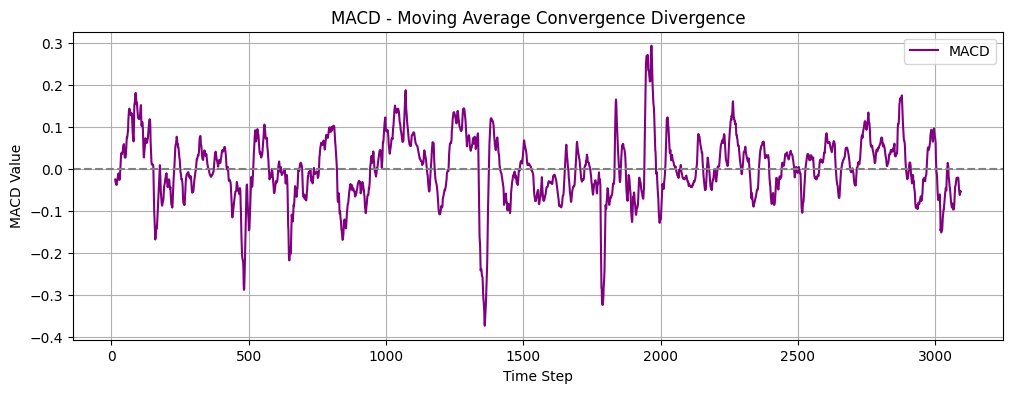

 Cleaned Data Shape: (3080, 7)
Price  Close  High   Low  Open    Volume        RSI      MACD
14      8.87  8.90  8.70  8.90  14031700  25.000149 -0.025369
15      8.90  8.94  8.82  8.86  14037600  29.411781 -0.029935
16      8.90  8.94  8.89  8.94  11364200  24.999925 -0.033172
17      8.91  9.03  8.90  9.01   9907500  27.272701 -0.034532
18      8.90  9.00  8.80  8.94  10224400  28.124991 -0.036001


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import date

#  Define date range
START = "2013-01-01"
TODAY = date.today().strftime("%Y-%m-%d")

#  Load data function
def load_data(ticker):
    data = yf.download(ticker, start=START, end=TODAY, auto_adjust=False)
    if data.empty:
        raise ValueError(f"No data found for ticker: {ticker}")
    data.reset_index(inplace=True)

    #  Flatten MultiIndex if present
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)

    return data

#  Ticker for Maybank (Malaysia)
ticker = '1155.KL'
df = load_data(ticker)
data = df.copy()

#  Drop unused columns safely
columns_to_drop = ['Date']
if 'Adj Close' in df.columns:
    columns_to_drop.append('Adj Close')
df = df.loc[:, ~df.columns.isin(columns_to_drop)]

#  RSI (Relative Strength Index - 14 period)
delta = df['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#  MACD (12-26 EMA)
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26

#  Drop rows with NaN values from indicators or MAs
df.dropna(inplace=True)

#  Moving Averages (for visualization only)
ma100 = df['Close'].rolling(100).mean()
ma200 = df['Close'].rolling(200).mean()

#  Plot 1: Close Price with MA100 & MA200
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price')
plt.plot(ma100, 'r', label='MA100')
plt.plot(ma200, 'g', label='MA200')
plt.title("Maybank (1155.KL) Stock Price with Moving Averages")
plt.xlabel("Time Step")
plt.ylabel("Price (MYR)")
plt.legend()
plt.grid(True)
plt.show()

#  Plot 2: RSI
plt.figure(figsize=(12, 4))
plt.plot(df['RSI'], label='RSI (14)', color='orange')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.title("RSI - Relative Strength Index")
plt.xlabel("Time Step")
plt.ylabel("RSI Value")
plt.grid(True)
plt.legend()
plt.show()

#  Plot 3: MACD
plt.figure(figsize=(12, 4))
plt.plot(df['MACD'], label='MACD', color='purple')
plt.axhline(0, color='gray', linestyle='--')
plt.title("MACD - Moving Average Convergence Divergence")
plt.xlabel("Time Step")
plt.ylabel("MACD Value")
plt.grid(True)
plt.legend()
plt.show()

#  Final check
print(" Cleaned Data Shape:", df.shape)
print(df.head())


In [3]:
df=data
df.head()

Price,Date,Adj Close,Close,High,Low,Open,Volume
0,2013-01-02,4.186037,9.03,9.10,9.03,9.09,4900700
1,2013-01-03,4.190672,9.04,9.08,9.03,9.05,8084400
2,2013-01-04,4.199944,9.06,9.08,9.03,9.04,10471100
3,2013-01-07,4.199944,9.06,9.12,9.05,9.06,6594700
4,2013-01-08,4.190672,9.04,9.07,9.02,9.06,9951900


In [4]:
# Splitting data into training and testing

train = pd.DataFrame(data[0:int(len(data)*0.70)])
test = pd.DataFrame(data[int(len(data)*0.70): int(len(data))])

print(train.shape)
print(test.shape)

(2165, 7)
(929, 7)


In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [6]:
train_close = train.iloc[:, 4:5].values
test_close = test.iloc[:, 4:5].values

In [7]:
data_training_array = scaler.fit_transform(train_close)
data_training_array

array([[0.5362694 ],
       [0.5362694 ],
       [0.5362694 ],
       ...,
       [0.26943007],
       [0.27461153],
       [0.27461153]])

In [8]:
import numpy as np
x_train = []
y_train = []

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [9]:
x_train.shape

(2065, 100, 1)

In [10]:
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight",
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer="glorot_uniform",
                                 trainable=True)
        self.b = self.add_weight(name="att_bias",
                                 shape=(input_shape[-1],),
                                 initializer="zeros",
                                 trainable=True)
        self.u = self.add_weight(name="att_u",
                                 shape=(input_shape[-1], 1),  # <- fix here
                                 initializer="glorot_uniform",
                                 trainable=True)
        super().build(input_shape)

    def call(self, inputs):
        v = tf.tanh(tf.tensordot(inputs, self.W, axes=[[2], [0]]) + self.b)  # (batch, time, features)
        vu = tf.tensordot(v, self.u, axes=[[2], [0]])  # (batch, time, 1)
        alphas = tf.nn.softmax(vu, axis=1)  # (batch, time, 1)
        output = tf.reduce_sum(inputs * alphas, axis=1)  # (batch, features)
        return output

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional

model = Sequential([
    tf.keras.Input(shape=(100, 3)),  # e.g., Close + RSI + MACD
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    AttentionLayer(),  # your custom attention layer
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        34,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 64)             │         4,224 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,513 (345.75 KB)

 Trainable params: 88,513 (345.75 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history_attention = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 8.5593e-04 - mae: 0.0213 - val_loss: 4.4688e-04 - val_mae: 0.0136
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.9786e-04 - mae: 0.0201 - val_loss: 8.1977e-04 - val_mae: 0.0239
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0011 - mae: 0.0247 - val_loss: 5.9202e-04 - val_mae: 0.0177
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.7155e-04 - mae: 0.0223 - val_loss: 4.7818e-04 - val_mae: 0.0152
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 8.4081e-04 - mae: 0.0204 - val_loss: 5.6864e-04 - val_mae: 0.0168
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.7477e-04 - mae: 0.0202 - val_loss: 4.5938e-04 - val_mae: 0.0144
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.7195e-04 - mae: 0.0211 - val_loss: 4.8354e-04 - val_mae: 0.0144
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 9.8126e-04 - mae: 0.0226 - val_loss: 8.6353e-04 - val_mae: 0.0

In [33]:
past_100_days = pd.DataFrame(train_close[-100:])

In [34]:
test_df = pd.DataFrame(test_close)

In [35]:
final_df = pd.concat([past_100_days, test_df], ignore_index=True)

In [36]:
final_df.head()

,0
0,8.17
1,8.18
2,8.27
3,8.30
4,8.24


In [37]:
input_data = scaler.fit_transform(final_df)
input_data

array([[0.09900997],
       [0.10231038],
       [0.1320134 ],
       ...,
       [0.55115519],
       [0.5544556 ],
       [0.55115519]])

In [38]:
input_data.shape

(1029, 1)

In [39]:
x_test = []
y_test = []
for i in range(100, input_data.shape[0]):
   x_test.append(input_data[i-100: i])
   y_test.append(input_data[i, 0])

In [40]:
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(929, 100, 1)
(929,)


In [41]:
# Making predictions

y_pred = model.predict(x_test)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [42]:
y_pred.shape

(929, 1)

In [43]:
y_test

array([0.05280523, 0.06270645, 0.08580866, 0.12211218, 0.12541259,
       0.1320134 , 0.1386139 , 0.1419143 , 0.10891088, 0.07590776,
       0.09240916, 0.08250826, 0.08580866, 0.07590776, 0.05940605,
       0.03960393, 0.03960393, 0.04290433, 0.03960393, 0.03960393,
       0.03960393, 0.03630368, 0.03960393, 0.05610564, 0.06270645,
       0.06270645, 0.05940605, 0.05610564, 0.05280523, 0.06600654,
       0.08250826, 0.07590776, 0.07590776, 0.06600654, 0.04290433,
       0.03630368, 0.02310237, 0.        , 0.01650171, 0.04290433,
       0.05610564, 0.06270645, 0.07920785, 0.08910907, 0.06930695,
       0.06600654, 0.06930695, 0.05940605, 0.06270645, 0.06930695,
       0.08910907, 0.10561047, 0.11221128, 0.11221128, 0.13531349,
       0.13531349, 0.1320134 , 0.11221128, 0.128713  , 0.1419143 ,
       0.14521471, 0.1386139 , 0.1320134 , 0.13531349, 0.1485148 ,
       0.17491742, 0.17491742, 0.18151823, 0.17161733, 0.14521471,
       0.128713  , 0.12541259, 0.10891088, 0.09900997, 0.11881

In [44]:
y_pred

array([[0.04415388],
       [0.04629451],
       [0.05282276],
       [0.06956962],
       [0.09967077],
       [0.11337209],
       [0.12055704],
       [0.12672529],
       [0.131271  ],
       [0.11136571],
       [0.08258882],
       [0.08164713],
       [0.07804681],
       [0.07876304],
       [0.07293889],
       [0.06052735],
       [0.04398853],
       [0.03739665],
       [0.03755371],
       [0.03633954],
       [0.03554384],
       [0.03505659],
       [0.03295677],
       [0.03380287],
       [0.04384214],
       [0.05239487],
       [0.05533772],
       [0.05374183],
       [0.05077137],
       [0.04764409],
       [0.05423014],
       [0.06756452],
       [0.06898715],
       [0.06834623],
       [0.06189167],
       [0.04571195],
       [0.03517893],
       [0.02418786],
       [0.00751981],
       [0.00905203],
       [0.02589384],
       [0.04206223],
       [0.05172261],
       [0.06444143],
       [0.07561781],
       [0.06737128],
       [0.06081235],
       [0.060

In [45]:
scaler.scale_

array([0.33003303])

In [46]:
y_pred = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((y_pred.shape[0], 2))), axis=1))[:, 0]
y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 2))), axis=1))[:, 0]

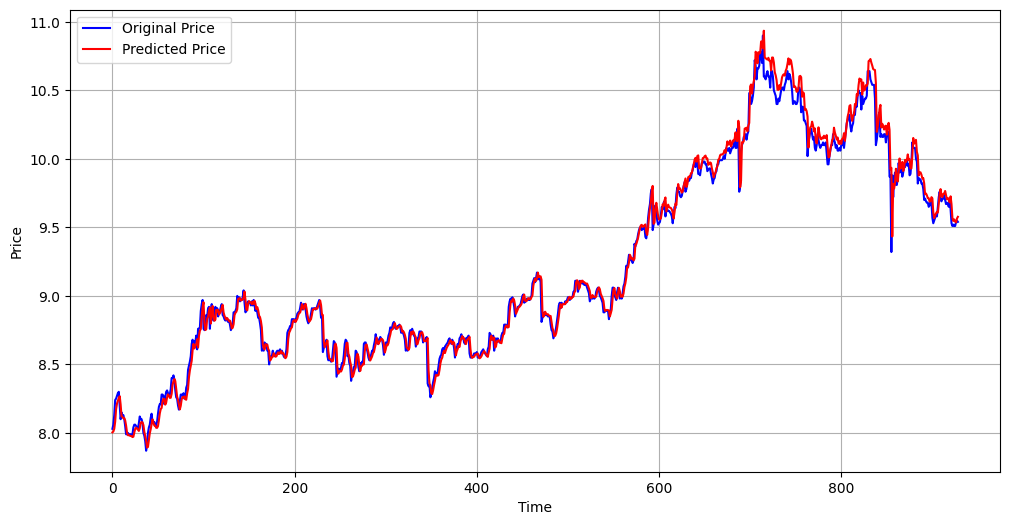

In [47]:
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(y_pred, 'r', label = "Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [49]:
# Core metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Optional: MAE as percentage
mae_pct = (mae / np.mean(np.abs(y_test))) * 100

# Display
print(f" Model Evaluation Metrics:")
print(f"MAE        : {mae:.2f}")
print(f"MAE (%)    : {mae_pct:.2f}%")
print(f"RMSE       : {rmse:.2f}")
print(f"R² Score   : {r2:.4f}")

 Model Evaluation Metrics:
MAE        : 0.05
MAE (%)    : 0.54%
RMSE       : 0.08
R² Score   : 0.9893


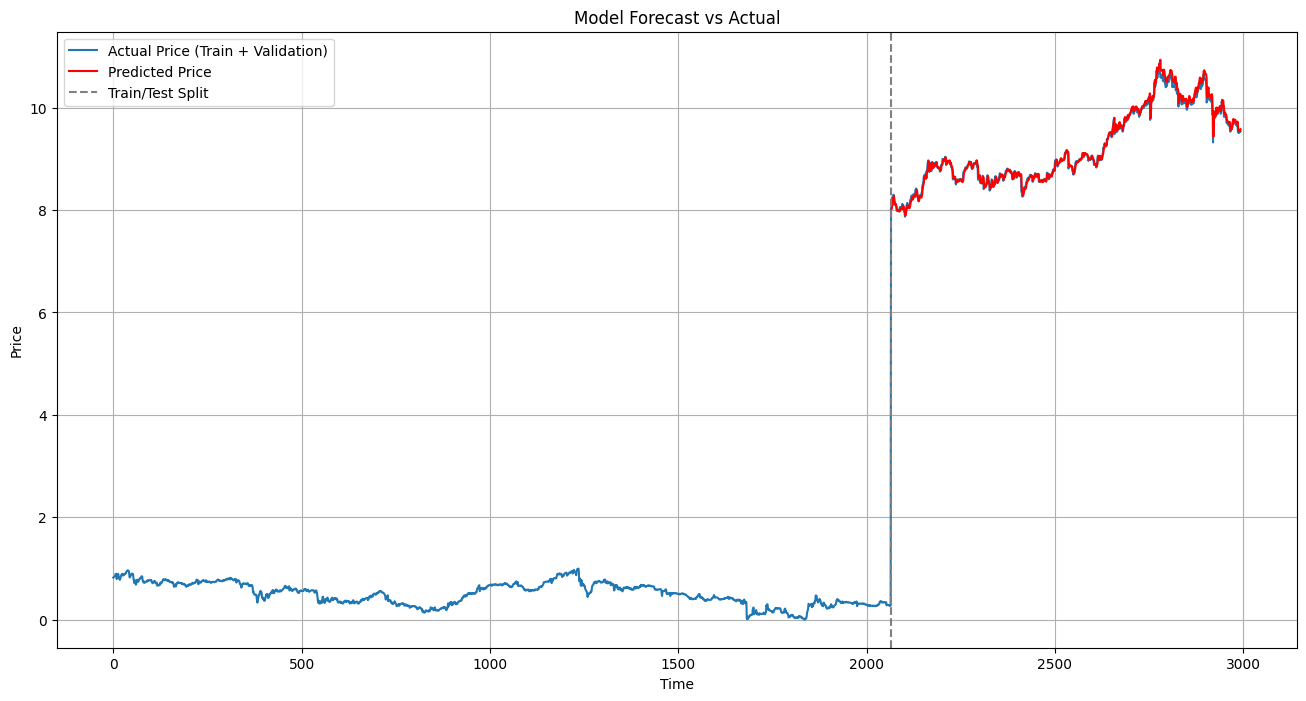

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# STEP 1: Reconstruct the full 'High' price series
# If you used y_train and y_test from the original 'High' column
full_actual = np.concatenate([y_train, y_test])
full_index = np.arange(len(full_actual))  # replace with date index if available

# STEP 2: Build a DataFrame to hold Actual and Predicted
df_plot = pd.DataFrame(index=full_index)
df_plot['High'] = full_actual
df_plot['Predictions'] = np.nan
df_plot.loc[len(y_train):, 'Predictions'] = y_pred  # place predictions aligned to validation set

# STEP 3: Plot it
plt.figure(figsize=(16, 8))
plt.title('Model Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Price')

plt.plot(df_plot['High'], label='Actual Price (Train + Validation)')
plt.plot(df_plot['Predictions'], label='Predicted Price', color='red')
plt.axvline(x=len(y_train), color='gray', linestyle='--', label='Train/Test Split')

plt.legend()
plt.grid(True)
plt.show()
